In [1]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import utils as u
from models import Generator, Discriminator
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from torch.utils.tensorboard.writer import SummaryWriter

# VARIÁVEIS

In [2]:
%%time

NOISE_DIM = 100
N_CAMADAS = 4  # ASSIM, O TAMANHO DA IMAGEM SERÁ N_CAMADAS*8. [1->8x8, 2->16x16, 3->32x32, 4->64x64, 5->128x128, 6->256x256]
IMG_SIZE = 4 * (2**N_CAMADAS)
IMG_CHANNELS = 3
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
MODELS_DIR = './models'
IMGS_DIR = './imgs/celeba'
TAXA_TREINAMENTO_DISCRIMINATOR = 5  # ou seja, o discriminator treina 5 vezes mais que o generator
LAMBDA_GP = 10 # TAXA DO GRADIENT PENALTY

def criar_transformer(img_size_):
    return  transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((img_size_, img_size_)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize(mean=(.5, .5, .5), std=(.5, .5, .5))
    ])
transformer = criar_transformer(img_size_=64)

inv_transformer = transforms.Compose([
    transforms.Normalize(mean=(-1., -1., -1.), std=(1., 1., 1.)),
    transforms.ToPILImage(),
])

print (f'{NOISE_DIM=}, {N_CAMADAS=}, {IMG_SIZE=}')

NOISE_DIM=100, N_CAMADAS=4, IMG_SIZE=64
CPU times: user 469 µs, sys: 84 µs, total: 553 µs
Wall time: 479 µs


In [3]:
writer = SummaryWriter('./logs/pg-wgan-celeba-4-camadas')
writer.add_text('mensagem inicial', '1ª fase do treinamento PG-GAN com quatro camadas iniciais + a camada final.Assim, o tamanho da imagem será de 64x64 pixels.')

# Inspeção de algumas imagens

len(dataset)=202599


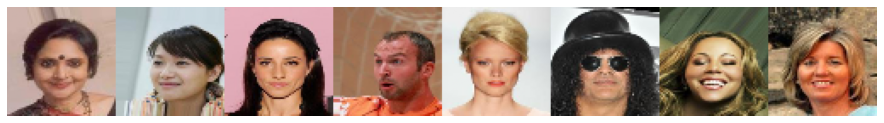

CPU times: user 1.41 s, sys: 112 ms, total: 1.52 s
Wall time: 1.42 s


In [4]:
%%time

dataset = u.Custom_Dataset(IMGS_DIR, '*.jpg', transformer, inv_transformer)
print (f'{len(dataset)=}')
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

grid_np = dataset.criar_grid_imagens_aleatorias(n_images=8, tipo='np')
plt.figure(figsize=(20, 2))
plt.imshow(grid_np)
plt.axis('off')
plt.show()

# Modelos discriminator e generator

In [5]:
discriminator = Discriminator(img_channels=IMG_CHANNELS, n_camadas=N_CAMADAS, cfl=128)
generator = Generator(img_channels=IMG_CHANNELS, noise_dim=NOISE_DIM, n_camadas=N_CAMADAS, cfl=512)

# Testando os modelos
noise = u.get_noise(3, NOISE_DIM)
output_generator = generator(noise)
output_discriminator = discriminator(output_generator)
print (f'{noise.shape=}')
print (f'{output_generator.shape=}')
print (f'{output_discriminator.shape=}')

noise.shape=torch.Size([3, 100, 1, 1])
output_generator.shape=torch.Size([3, 3, 64, 64])
output_discriminator.shape=torch.Size([3, 1, 1, 1])


# Funções úteis para o treinamento

In [6]:
def gradient_penalty(model_d, real_imgs, fake_imgs, device_):

    b_size, c, h, w = real_imgs.shape
    alpha = torch.rand((b_size, 1, 1, 1)).repeat(1, c, h, w).to(device_)
    # tenta criar um tensor (b,c,h,w) onde cada elemento b (de dim c,h,w) possui um número aleatório em todas as posições

    interpolated_imgs = real_imgs * alpha + fake_imgs * (1-alpha)

    # Cálculo score
    mixed_score = model_d(interpolated_imgs)

    gradient = torch.autograd.grad(
        inputs = interpolated_imgs,
        outputs = mixed_score,
        grad_outputs = torch.ones_like(mixed_score),
        create_graph = True,
        retain_graph = True
    )[0]
    
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm-1) ** 2)
    
    return penalty

def imprimir_imagem_checkpoint():
    random_noise = u.get_noise(8, NOISE_DIM, device)
    random_img = generator(random_noise)
    img_np = u.criar_grid(random_img, nrow=8, inv_transformer=inv_transformer, tipo='np')
    plt.figure(figsize=(20, 4))
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

# Preparação para treinamento

In [7]:
discriminator = Discriminator(img_channels=3, n_camadas=N_CAMADAS, cfl=128)
generator = Generator(img_channels=3, noise_dim=NOISE_DIM, n_camadas=N_CAMADAS, cfl=512)

print ('Importando modelo discriminator...')
discriminator.load_checkpoint('./models/Discriminator_3_layer.pt')
print ('==============================================================\n\n')

print ('Importando modelo generator...')
generator.load_checkpoint('./models/Generator_3_layer.pt')
print ('==============================================================\n\n')

noise = u.get_noise(1, NOISE_DIM)
output_generator = generator(noise)
IMG_SIZE = output_generator.shape[-1]

print (f'Treinamento com {N_CAMADAS=} e tamanho das imagens {IMG_SIZE=}')
transformer = criar_transformer(img_size_=IMG_SIZE)
print (f'Transformers criados.')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print (f'{device=}')

discriminator.to(device)
generator.to(device)

optim_generator = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0., 0.9))
optim_discriminator = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0., 0.9))

dataset = u.Custom_Dataset(IMGS_DIR, pattern='*.jpg', transformer=transformer, inv_transformer=inv_transformer)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print (f'{len(dataset)=}, {BATCH_SIZE=}, {len(dataloader)=}')

checkpoint = torch.load('./models/Generator_3_layer.pt')
last_epoch = checkpoint['epochs']
print (f'{last_epoch=}')

print (f'ok')

Importando modelo discriminator...
cfl=128, img_channels=3, tempo='28/02/2022, 20:04'
primeira <All keys matched successfully>
segunda <All keys matched successfully>
terceira <All keys matched successfully>


Importando modelo generator...
noise_dim=100, cfl=512, img_channels=3, tempo='28/02/2022, 20:04'
primeira <All keys matched successfully>
segunda <All keys matched successfully>
terceira <All keys matched successfully>


Treinamento com N_CAMADAS=4 e tamanho das imagens IMG_SIZE=64
Transformers criados.
device=device(type='cuda', index=0)
len(dataset)=202599, BATCH_SIZE=128, len(dataloader)=1583
last_epoch=54
ok


# Treinamento

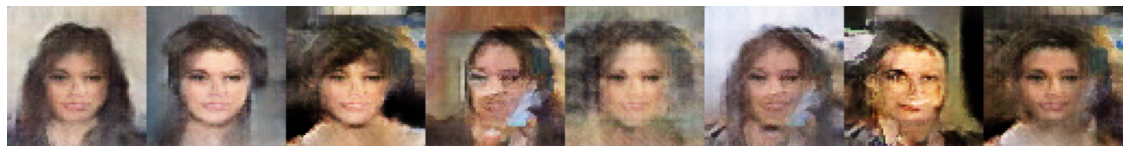

epoch=3


  2%|▏         | 27/1583 [01:54<1:51:51,  4.31s/it]

In [ ]:
generator.train()
discriminator.train()

for epoch in range(last_epoch + 1, last_epoch + 11, 1):

    clear_output(wait=True)

    imprimir_imagem_checkpoint()
    
    print (f'{epoch=}')

    for real_imgs in tqdm(dataloader):
        real_imgs = real_imgs.to(device)
        b_size = len(real_imgs)

        # Treinando o discriminator
        for _ in range(TAXA_TREINAMENTO_DISCRIMINATOR):
            noise = u.get_noise(b_size, NOISE_DIM, device)
            fake_imgs = generator(noise)

            output_real = discriminator(real_imgs)
            output_fake = discriminator(fake_imgs)

            # Cálculo do Gradient-penalty
            gp = gradient_penalty(discriminator, real_imgs, fake_imgs, device)
            loss_discriminator = -(torch.mean(output_real.view(-1)) - torch.mean(output_fake.view(-1))) + LAMBDA_GP*gp
            discriminator.zero_grad()
            loss_discriminator.backward(retain_graph=True)
            optim_discriminator.step()
        
        # Treinando o generator
        output_fake_for_generator = discriminator(fake_imgs)
        loss_generator = -torch.mean(output_fake_for_generator.view(-1))
        generator.zero_grad()
        loss_generator.backward()
        optim_generator.step()

    # Levando as variáveis para o tensorboard
    writer.add_scalar('loss_discriminator', loss_discriminator.item(), epoch)
    writer.add_scalar('loss_generator', loss_generator.item(), epoch)
    
    discriminator.save(epoch)
    generator.save(epoch)

In [9]:
writer.close()